In [1]:
obj_dims = (648, 486)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import backend as K
from tensorflow.keras import layers

import os
import json
import scipy.io as sio
from os import path

from src.model import UNet_2d
from src.utils import *
from src.forward_model import *

import PIL
from PIL import Image

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [4]:
model_description = 'model-13.1'

In [5]:
real_data_path = path.join('..', 'data', 'real-data', 'realData.mat')
ground_truth_path = path.join('..', 'data', 'real-data', 'beads_GT.png')

real_res_target_path = '../data/real-data/res_target_z1.tif'

# Paths for saving/loading model weights, predictions
base_path = path.join('..', 'models', model_description)
model_weights_path = path.join(base_path, model_description)
image_path = path.join(base_path, 'prediction-images')

# Testing

In [6]:
model = UNet_2d()
epoch = 'best'
model.load_weights(model_weights_path + '.{}'.format(epoch))

In [7]:
# Read in older mat files with scipy.io
data = sio.loadmat(real_data_path)

In [8]:
beads, res = data['beads'], data['resTarget']
beads = np.array(Image.fromarray(beads).resize(obj_dims, resample=PIL.Image.NEAREST))
beads_input_normed = normalize(beads).T
beads_input = beads_input_normed.astype(np.float16)[np.newaxis, ..., np.newaxis]

In [9]:
# res = np.array(Image.fromarray(res).resize(obj_dims, resample=PIL.Image.NEAREST))
# res_input_normed = normalize(res).T
# res_input = res_input_normed.astype(np.float16)[np.newaxis, ..., np.newaxis]

In [10]:
# Load in real res target data
real_res = np.array(Image.open(real_res_target_path).resize(obj_dims, resample=PIL.Image.NEAREST))
real_res_normed = normalize(real_res).T
real_res_input = real_res_normed.astype(np.float16)[np.newaxis, ..., np.newaxis]

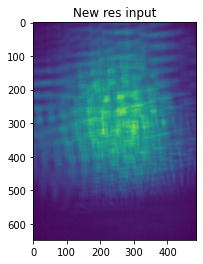

In [11]:
plt.figure()
plt.imshow(real_res_normed)
plt.title('New res input')
plt.show()

In [12]:
pred_beads = model.predict(beads_input).squeeze()

In [13]:
pred_res_real = model.predict(real_res_input).squeeze()

In [14]:
beads_gt_im = Image.open(ground_truth_path)
beads_gt = np.array(beads_gt_im).T
# Normalize beads from 0 to 1
beads_gt = normalize(beads_gt)

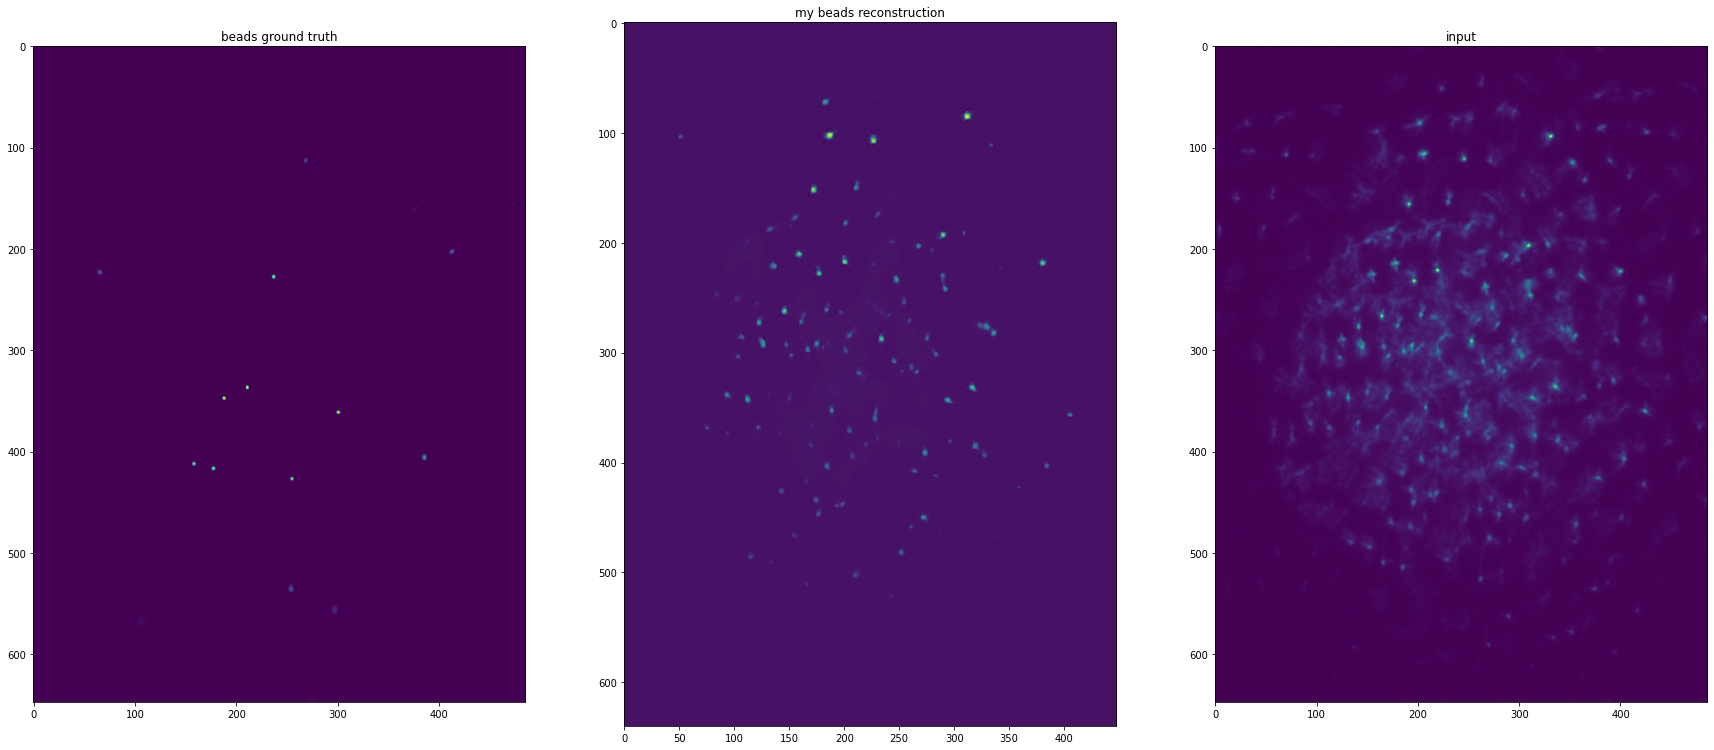

In [15]:
fig = plt.figure(figsize=(30, 30))
f0 = fig.add_subplot(1, 3, 1)
f0.set_title('beads ground truth')
f0.imshow(beads_gt)

f1 = fig.add_subplot(1, 3, 2)
f1.set_title('my beads reconstruction') # Normalized before simulation, but not after
f1.imshow(pred_beads)

f2 = fig.add_subplot(1, 3, 3)
f2.set_title('input')
f2.imshow(beads_input_normed)


plt.savefig(path.join(image_path, '{}_beads_reconstruction_{}.pdf'.format(model_description, epoch)))
plt.show()


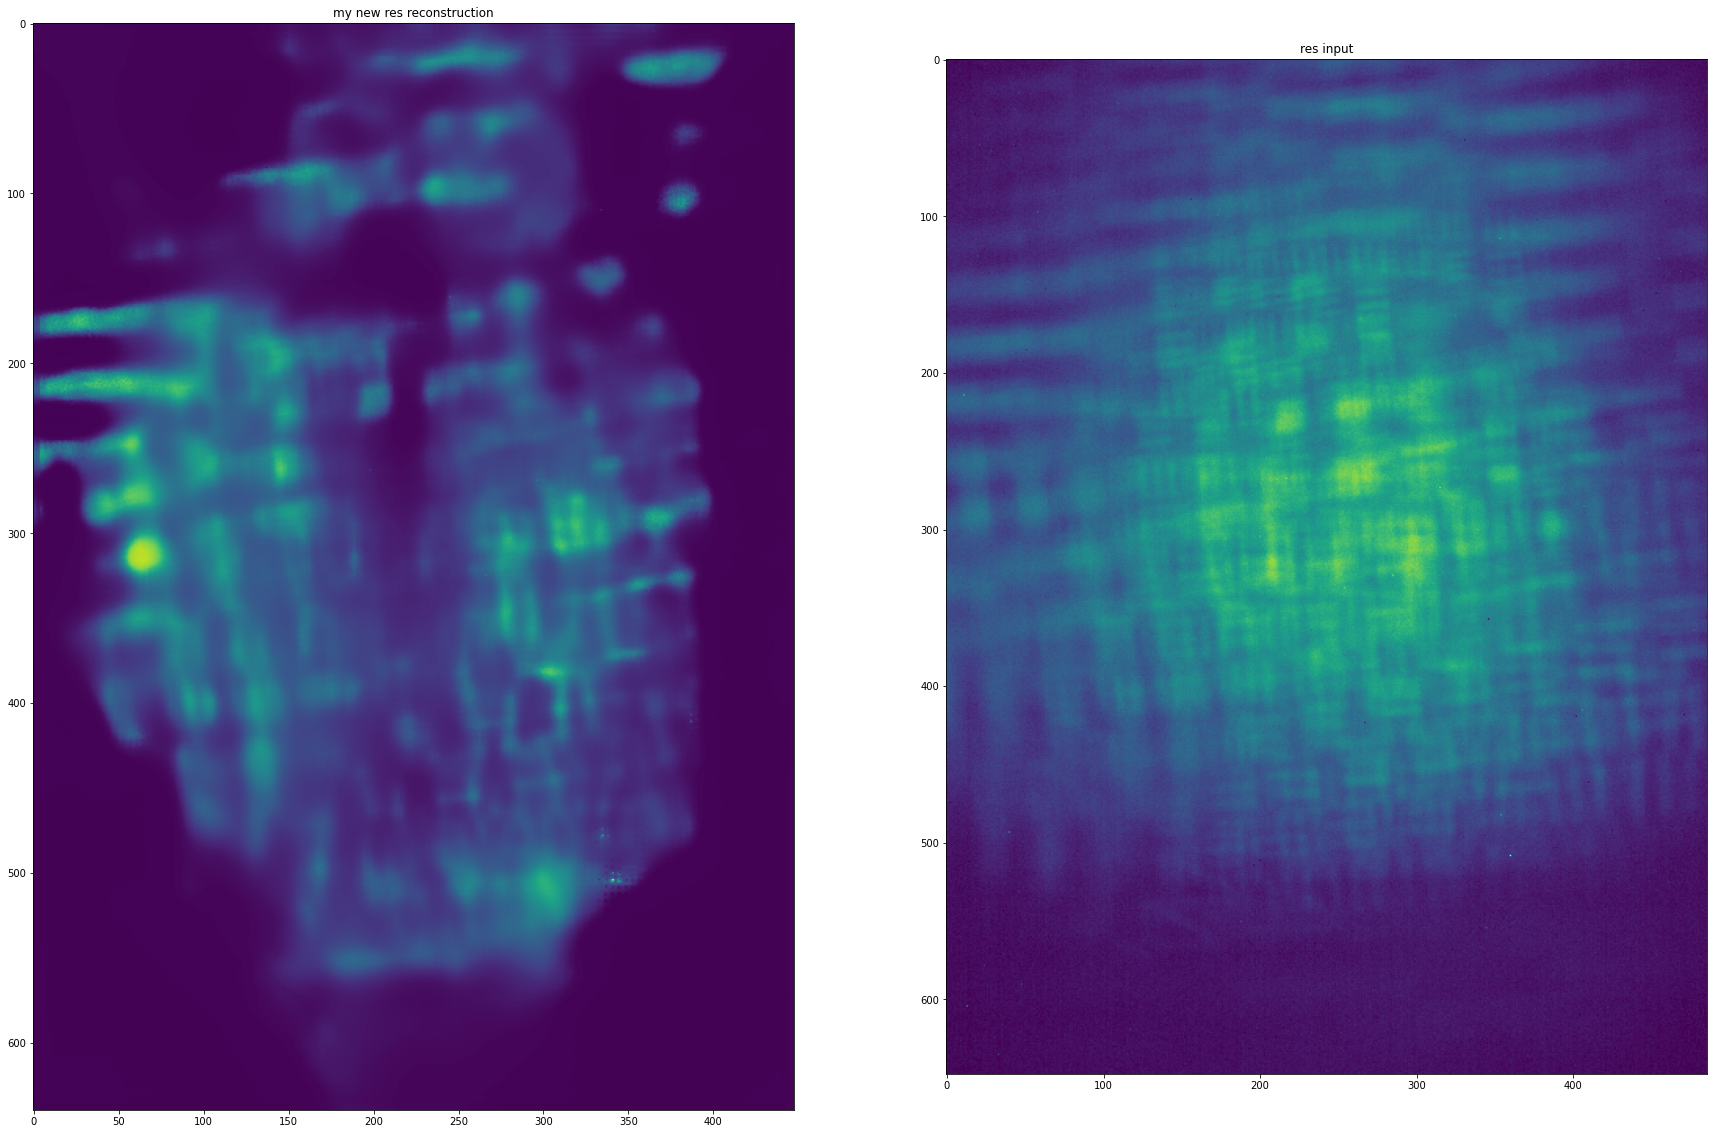

In [16]:
fig = plt.figure(figsize=(30, 30))


f1 = fig.add_subplot(1, 2, 1)
f1.set_title('my new res reconstruction') # Normalized before simulation, but not after
f1.imshow(pred_res_real)

f3 = fig.add_subplot(1, 2, 2)
f3.set_title('res input')
f3.imshow(real_res_normed)

plt.savefig(path.join(image_path, '{}_res_reconstruction_{}.pdf'.format(model_description, epoch)))

plt.show()

# With Wiener Deconvolution

In [17]:
comps_path = '/home/rshuai/research/u-net-reconstruction/data/PSFs/processed/rank24_z0_ds2_normalized/comps.npy'
weights_path = '/home/rshuai/research/u-net-reconstruction/data/PSFs/processed/rank24_z0_ds2_normalized/weights.npy'

In [18]:
# Load in comps and weights
h = np.load(comps_path)
weights = np.load(weights_path)

In [20]:
psf = tf.math.reduce_sum(h*weights, axis=0)
psf = psf / tf.math.reduce_max(psf)
K = 2000 #this variable can be learned, it has be greater than zero though


In [21]:
Niter = 20

fm = ForwardModel()

# res_wiener = normalize(fm.wiener_deconvolve(real_res_normed, weights, h, Niter))
# beads_wiener = normalize(fm.wiener_deconvolve(beads_input_normed, weights, h, Niter))

res_wiener = normalize(fm.wiener_deconvolve_one_step(real_res_normed, psf, K))
beads_wiener = normalize(fm.wiener_deconvolve_one_step(beads_input_normed, psf, K))

In [22]:
beads_pred = model.predict(beads_wiener[None, ..., None]).squeeze()
res_pred = model.predict(res_wiener[None, ..., None]).squeeze()


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



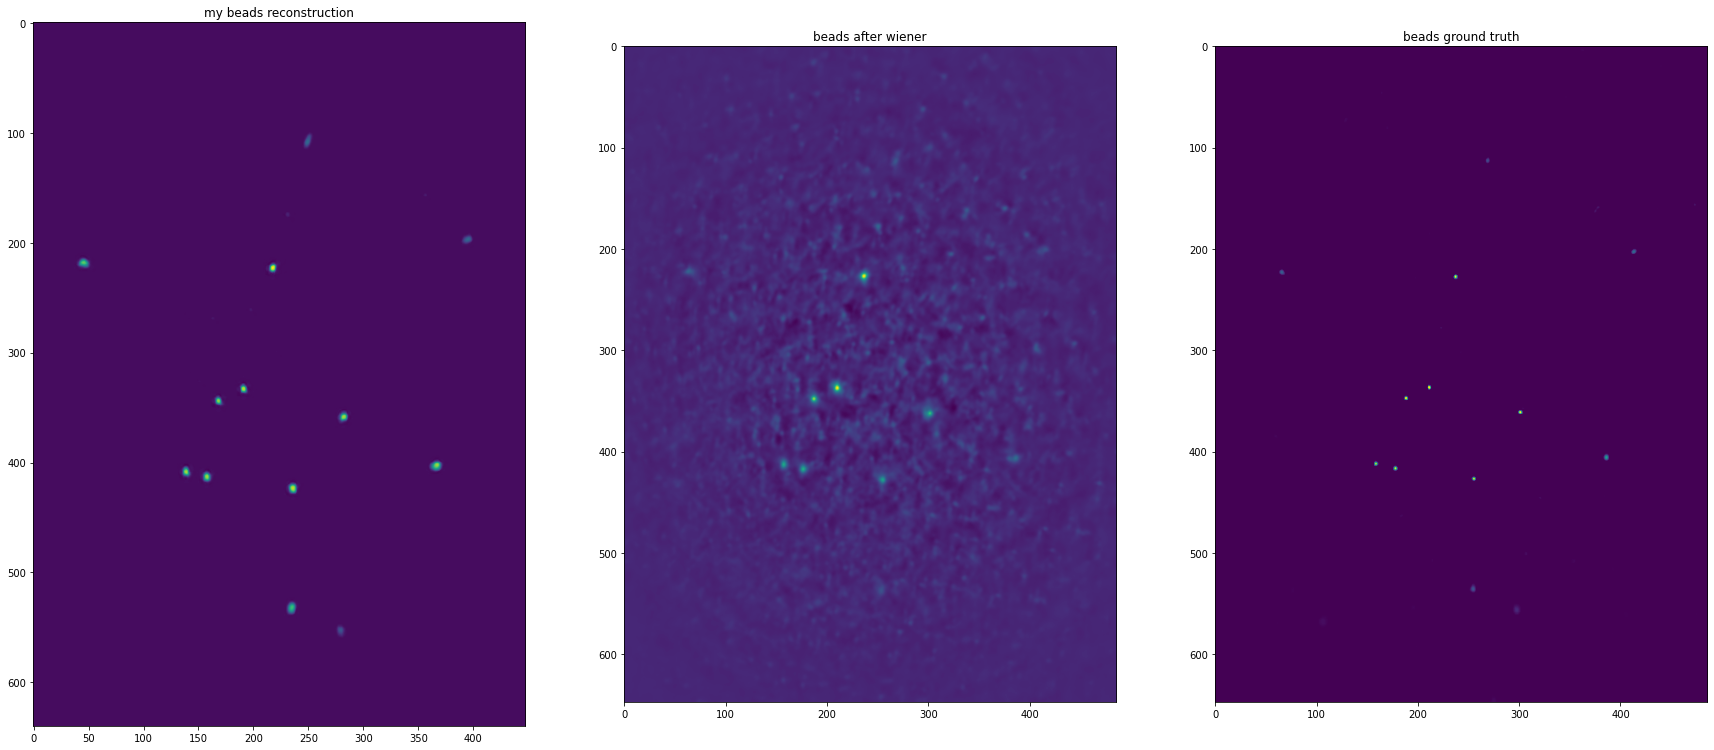

In [23]:
fig = plt.figure(figsize=(30, 30))

f1 = fig.add_subplot(1, 3, 1)
f1.set_title('my beads reconstruction') # Normalized before simulation, but not after
f1.imshow(beads_pred)

f2 = fig.add_subplot(1, 3, 2)
f2.set_title('beads after wiener')
f2.imshow(beads_wiener)

f0 = fig.add_subplot(1, 3, 3)
f0.set_title('beads ground truth')
f0.imshow(beads_gt)

plt.savefig(path.join(image_path, '{}_beads_reconstruction_{}.pdf'.format(model_description, epoch)))
plt.show()


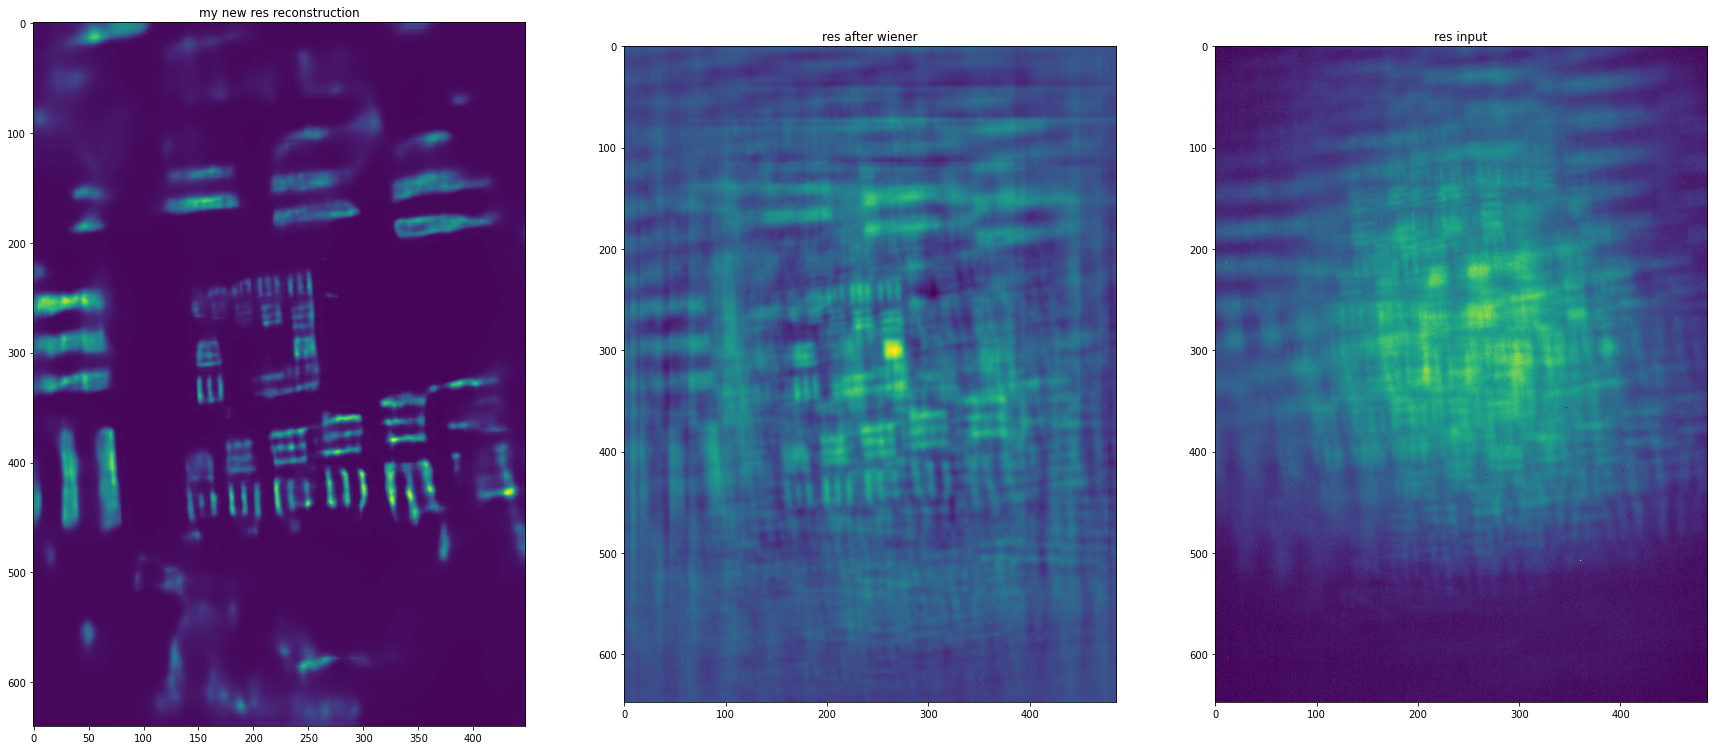

In [24]:
fig = plt.figure(figsize=(30, 30))


f1 = fig.add_subplot(1, 3, 1)
f1.set_title('my new res reconstruction') # Normalized before simulation, but not after
f1.imshow(res_pred)

f2 = fig.add_subplot(1, 3, 2)
f2.set_title('res after wiener')
f2.imshow(res_wiener)

f3 = fig.add_subplot(1, 3, 3)
f3.set_title('res input')
f3.imshow(real_res_normed)



plt.savefig(path.join(image_path, '{}_res_reconstruction_{}.pdf'.format(model_description, epoch)))

plt.show()

In [23]:
print(normalize(fm.wiener_deconvolve(normalize(real_res.T), weights, h, Niter)))

tf.Tensor(
[[0.33967966 0.34075314 0.3398717  ... 0.3124419  0.31001475 0.30622277]
 [0.34076357 0.34228694 0.3430843  ... 0.3159551  0.3143262  0.3102805 ]
 [0.34087074 0.34392914 0.34425792 ... 0.3220984  0.31966972 0.31495428]
 ...
 [0.34869266 0.34923592 0.34878647 ... 0.35168967 0.35140407 0.3496232 ]
 [0.3496443  0.34999382 0.3504003  ... 0.3517195  0.35119942 0.34859937]
 [0.35053954 0.3507916  0.35149446 ... 0.35042685 0.35096824 0.34811994]], shape=(648, 486), dtype=float32)


In [24]:
print(normalize(fm.wiener_deconvolve(real_res.T, weights, h, Niter)))

tf.Tensor(
[[0.3397425  0.34081402 0.33993334 ... 0.31251258 0.31008726 0.3062995 ]
 [0.34082556 0.34234643 0.34314206 ... 0.31602445 0.314397   0.31035498]
 [0.340934   0.34398764 0.34431532 ... 0.32216296 0.31973633 0.31502512]
 ...
 [0.34872645 0.34927067 0.34882346 ... 0.35173672 0.35145023 0.34967023]
 [0.34967676 0.35002756 0.35043538 ... 0.35176575 0.351245   0.3486469 ]
 [0.35057032 0.3508236  0.35152727 ... 0.35047373 0.35101315 0.34816697]], shape=(648, 486), dtype=float32)


In [25]:
x = normalize(fm.wiener_deconvolve(real_res.T, weights, h, Niter))
z = normalize(fm.wiener_deconvolve(normalize(real_res.T), weights, h, Niter))

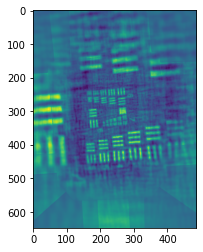

In [44]:
plt.imshow(x)

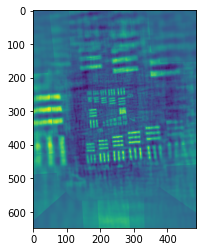

In [45]:
plt.imshow(z)